# Forward simulation of Burgers Equation with $\phi$Flow

### Model

$$\frac{\partial{u}}{\partial{t}} + u\nabla u = \nu \nabla * \nabla u$$

In [8]:
from phi import __version__
import phi.flow as pf

import numpy as np
print("Using phiflow version: {}".format(__version__))

Using phiflow version: 2.0.0rc2


In [32]:
N = 128
STEPS = 32
DT = 1/STEPS
NU = 0.01/np.pi

# initialization of velocities
INITIAL_NUMPY = np.asarray( [-np.sin(np.pi * x) * 1. for x in np.linspace(-1,1,N)] )**2
INITIAL = pf.math.tensor(INITIAL_NUMPY, pf.spatial('x')) # convert np array to phiflow tensor

In [33]:
velocity = pf.CenteredGrid(INITIAL, pf.extrapolation.PERIODIC, x=N, bounds=pf.Box[-1:1])
print("Velocity tensor shape: " + format(velocity.shape))
print("Velocity tensor type: " + format(type(velocity.values)))
print("Velocity tensor entries 10 to 14: " + format(velocity.values.numpy()[10:15]))


Velocity tensor shape: (xˢ=128)
Velocity tensor type: <class 'phi.math._tensors.CollapsedTensor'>
Velocity tensor entries 10 to 14: [0.2254369  0.26805974 0.31295157 0.35967324 0.40776768]


### Running the simulation

In [34]:
velocities = [velocity]
age = 0.
for i in range(STEPS):
    v1 = pf.diffuse.explicit(velocities[-1], NU, DT)
    v2 = pf.advect.semi_lagrangian(v1, v1, DT)
    age += DT
    velocities.append(v2)
    
print("New velocity content at t={}: {}".format(age, velocities[-1].values.numpy()[0:5]))

New velocity content at t=1.0: [0.06284304 0.00318846 0.00719161 0.01306719 0.0199014 ]


In [35]:
import pylab

In [36]:
vels = [v.values.numpy('x,vector') for v in velocities]

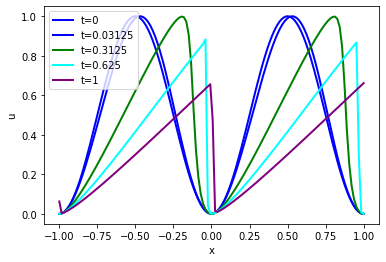

In [37]:
fig = pylab.figure().gca()

fig.plot(np.linspace(-1,1,len(vels[0].flatten())), vels[0].flatten(), lw=2, color="blue", label="t=0")
fig.plot(np.linspace(-1,1,len(vels[1].flatten())), vels[1].flatten(), lw=2, color="blue", label="t="+str(DT))
fig.plot(np.linspace(-1,1,len(vels[10].flatten())), vels[10].flatten(), lw=2, color="green", label="t=0.3125")
fig.plot(np.linspace(-1,1,len(vels[20].flatten())), vels[20].flatten(), lw=2, color="cyan", label="t=0.625")
fig.plot(np.linspace(-1,1,len(vels[32].flatten())), vels[32].flatten(), lw=2, color="purple", label="t=1")
pylab.xlabel('x'); pylab.ylabel('u'); pylab.legend()

In [38]:
def show_state(a, title):
    # we only have 33 time steps, blow up by a factor of 2^4 to make it easier to see
    a = np.expand_dims(a, axis=2)
    for i in range(4):
        a = np.concatenate([a,a], axis=2)
        
    a = np.reshape(a, [a.shape[0], a.shape[1]*a.shape[2]])

    fig, axes = pylab.subplots(1,1, figsize=(16,5))
    im = axes.imshow(a, origin='upper', cmap='inferno')
    pylab.colorbar(im); pylab.xlabel('time'); pylab.ylabel('x'); pylab.title(title)

In [39]:
vels_img = np.asarray(np.concatenate(vels, axis=-1), dtype=np.float32)

In [40]:
# save for comparison
import os; os.makedirs('./temp', exist_ok=True)
np.savez_compressed('./temp/burgers-groundtruth-solution.npz', np.reshape(vels_img, [N, STEPS+1]))


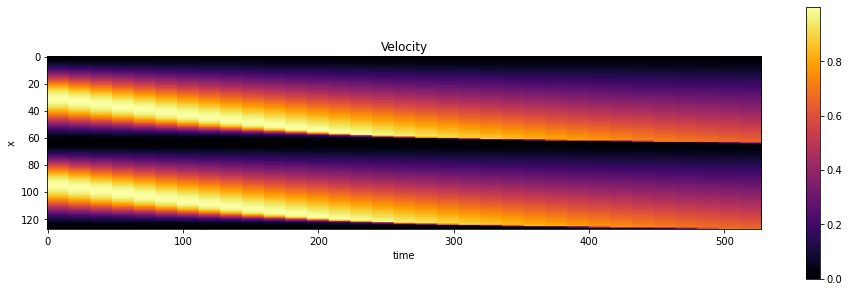

In [41]:
show_state(vels_img, 'Velocity')